In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/XAI/

/content/gdrive/MyDrive/XAI


In [ ]:
#from random import shuffle
!pip install folium
!pip install catboost
import folium

import pickle
import math
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import keras
import random as rn

import tensorflow as tf
#tf.compat.v1.disable_v2_behavior()
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn.functional as F
#from torch_geometric.nn.dense import DenseGCNConv
from keras.layers import Activation, Dense
from numpy import array as narray
from numpy import inf, median
from tensorflow.keras.optimizers import SGD,Adagrad, Adam, RMSprop

import easydict
import os
#import cupy #런타임 gpu 사용시
import argparse
import dill
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import atan
#런타임gpu사용시
#from cupy import zeros, full, where, identity, divide, add, array, ndarray, asarray, asnumpy, stack, vstack, subtract, newaxis, multiply, ones, less, minimum, copy, concatenate, exp, repeat, tile, matmul, isnan, sqrt, log, NaN#, nanmean

import time
from queue import Queue
from sklearn.metrics import mean_squared_error
#geopandas
!pip install geopandas
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler

!pip install shap
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
#from matplotlib import pyplot as pltfrom sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.6 MB/s 
     |████████████████████████████████| 16.7 MB 320 kB/s 
     |████████████████████████████████| 6.3 MB 44.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.1 MB/s 


In [ ]:
#1차 전처리
def InfoMatrix(g) :
    adj = np.zeros((g.shape[0], g.shape[0])) # adj 초기화
    for i in range(g.shape[0]) :
        idx = g[g['dst'] == g.at[i, 'src']].index.tolist() #연결이 되어 있으면 idx로 인덱스 정보 추출
        idx.extend(g[g['src'] == g.at[i, 'dst']].index.tolist())
        #print('IDS shape check : ',np.shape(idx))
        adj[i, idx] = 1 # 인접행렬을 생성
    return adj

def BaseInfo() : # 데이터 로드
    speed = pickle.load(open('2018_5pclean_tMatrix.pkl', 'rb')) # 속도 데이터 로드
    g = pickle.load(open('Graph_info.pkl', 'rb')).sort_values(by=['str_id']).reset_index(drop = True) # 인접관계 정보 데이터 로드

    # End Point 변환
    g.loc[g[g['dst'].isin(['힐튼'])].index,'dst'] = '도동삼거리'
    g.loc[g[g['dst'].isin(['힐튼'])].index,'dist'] = 322

    speed.drop(['3201500100'], axis = 1, inplace = True) # 기후 정보가 없는 링크 드랍
    g = g[g['str_id'] != '3201500100'].sort_values(by=['str_id']).reset_index(drop = True)
    g = g.sort_values(by=['str_id']).reset_index(drop = True)

    linklist = g['str_id'].values # 링크 ID 추출
    dist = g['dist'].astype(int).values # 거리 데이터 추출

    #adj = InfoMatrix(g) # 인접행렬 adj랑, cost행렬 추출
    dist = np.asarray(dist)
    #speed = np.asarray(speed.values)
    speed = np.asarray(speed.values).astype('float32')

    hopadj = pickle.load(open('tg1_hopadj.picle', 'rb'))
    lnewspeed = pickle.load(open('lnewspeed.picle', 'rb')) #local 노드별  scaled 된 속도 데이터 로드
    gnewspeed = pickle.load(open('gnewspeed.picle', 'rb')) #global하게  scaled 된 속도 데이터 로드
    return hopadj, g, speed, lnewspeed, gnewspeed


#hop count 계산 -> BFS알고리즘사용
def bfs(adj, start_node):
  x= len(adj)
  visit=[0]*x
  ch = [0]*x
  q = Queue()
  for s in np.where(adj[start_node]==1)[0]:
    q.put(s)
    visit[s]=1
    ch[s]=1
  while q.qsize()>0 :
    node = q.get()
    for nextN in np.where(adj[node]==1)[0]:
      if nextN != start_node and ch[nextN]==0:
        ch[nextN]=1
        q.put(nextN)
        visit[nextN]=visit[node]+1
  return visit

def make_hopadj(adj): #hop count matrix 생성
  tg1_hopadj=[]
  for i in range(len(adj)):
    tg1_hopadj.append(bfs(adj, i))

  with open('tg1_hopadj.picle', 'wb') as f:
    pickle.dump(tg1_hopadj, f)

In [ ]:
def make_features(hopadj,speed, obj, tg):

  #print(np.shape(hopadj))#(4670, 4670)
  check = True
  input_tg=[]
  for t in (obj): # (실험용) 노드에 대해서
    features=[] #(#hop5노드들 + 시각 + 요일,) 으로 features 표현 :
    features.append(speed[t][tg].item()) # 해당 노드의 t시간대 속도
    for cnt in range(1,6): #hop count 1~5 까지
      hop_idx =  np.where(np.array(hopadj[tg])==cnt)[0]
      #print(hop_idx)
      features.extend(speed[t][hop_idx])
    features.append( ( t%24 +1 )/24) #시각
    features.append( ( (t//24)%7 + 1 ) /7 ) #요일
    input_tg.append(features)

  if check:
    check=False
    #print('input_tg shape : (pred:  (#train or test , hop5이내 + 3)) vs ',np.shape(input_tg))# 2차원 (#train or test , hop5이내 갯수 + 3(자기자신속도,시각, 요일))

  return input_tg

def make_output(speed, obj, tg): #t시간대의 output --> t+1의 값
  output_tg = []
  for t in (obj):
    output_tg.append(speed[t+1][tg]) # 특정 시간 t에서의 전체 노드의 speed
  #print('output_tg shape : (pred:  (#train or test ) vs', np.shape(output_tg )) #(train or test,)
  return output_tg


def make_features_simulation(hopadj,speed, t, tg):

  feature=[] #(#hop5노드들 + 시각 + 요일,) 으로 features 표현 :
  feature.append(speed[t][tg].item()) # 해당 노드의 t시간대 속도

  for cnt in range(1,6): #hop count 1~5 까지
    hop_idx =  np.where(np.array(hopadj[tg])==cnt)[0]
    feature.extend(speed[t][hop_idx])
  feature.append( ( t%24 +1 )/24) #시각
  feature.append( ( (t//24)%7 + 1 ) /7 ) #요일

  return feature

In [ ]:
def RMSE(y_test, y_predict): #판단 지표
    return np.sqrt(mean_squared_error(y_test, y_predict))


def MAPE(y_test, y_predict): #판단 지표
    return np.mean(np.abs((y_test-y_predict)/y_test))*100

In [ ]:
from catboost.core import CatBoostRegressor
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])

  train_dataset = cb.Pool(input_train_df, output_train_df)
  test_dataset = cb.Pool(input_test_df, output_test_df)

  model = cb.CatBoostRegressor(loss_function= 'RMSE')
  model.fit(train_dataset)
  #print(model_cr.summary())

  ii = model.predict(input_test_df)
  print(np.shape(ii))

  ii = ii*130+0.74
  oo = output_test*130+0.74

  print('==========추가 결과값: 속도로 계산=========')
  print('실제 속도로 본 RMSE :  ',RMSE(oo, ii)) # 실제, predict

  from sklearn.metrics import mean_absolute_error
  print("MAE:",mean_absolute_error(oo,ii))

  print("MAPE:",MAPE(oo,ii))

  #model.save_model("model_sklearn_xgb.json"+scaled+str(tg))
  model.save_model("model")




hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
Learning rate set to 0.054166
0:	learn: 0.0362028	total: 111ms	remaining: 1m 50s
1:	learn: 0.0349640	total: 143ms	remaining: 1m 11s
2:	learn: 0.0338183	total: 177ms	remaining: 58.9s
3:	learn: 0.0327427	total: 209ms	remaining: 52.1s
4:	learn: 0.0317303	total: 241ms	remaining: 48s
5:	learn: 0.0307833	total: 274ms	remaining: 45.4s
6:	learn: 0.0299615	total: 315ms	remaining: 44.8s
7:	learn: 0.0291626	total: 347ms	remaining: 43s
8:	learn: 0.0283874	total: 378ms	remaining: 41.7s
9:	learn

In [ ]:
print(model.feature_importances_)

[ 6.49918436  0.3946802   0.22832517  3.70070021  1.13730366  0.59448721
  1.29268079  0.6330078   1.7857867   0.42930446  0.26354674  0.6151368
  1.26630818  0.45854219  0.26150761  0.80845426  0.57056406  0.68282591
  0.5531752   0.45494382  0.25308545  0.45798403  0.39944362  0.36449518
  0.55817469  1.47803793  0.2976815   0.33040712  0.34757144  0.38782991
  0.59293335  0.65291057  0.50384042  0.75115249  0.93560362  0.38443805
  0.56102672  0.45682524  0.54028731  0.45854196  0.22270642  0.51613535
  0.51586298  0.26424758  0.46392722  0.49091405  0.73871267  0.6048675
  0.56705585  0.22152506  0.48026593  0.2842668   0.75438163  0.18205621
  0.34038998  0.4394558   1.06761806  0.46559322  0.28916812  0.93651045
  0.52433263  0.72088588  0.60888641  0.56486097  0.48409051  0.61924154
  0.37802517  0.37330367  0.54187901  0.74534676  0.52019323  0.27375451
  0.27309719  0.33282215  0.90935556  0.58099061  0.63971031  0.25995338
  0.47326144  0.41694057  0.75824252  0.63541916  0.2

In [ ]:
input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629','2978','2983','2984','3156',
                                                      '3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134',
           '3136','3153','3157','3159','3167','3175','3186','3198','3230','3255',
           '3258','4632','4641','393','395','397','445','470','2082','2084',
           '2085','2087','2145','2974','2977','3114','3115','3116','3117','3123',
           '3127','3129','3135','3137','3152','3166','3174','3179','3231','3259',
           '3268','3352','176','389','392','394','446','455','456','469',
           '477','2086','2088','2091','2093','2146','2147','2148','2152','2158',
           '2164','2970','2975','3122','3178','3185','3211','3261','3269','3278',
           '3294','3295','3344','3351','3353','3354','3355','clock_time','day'])

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
sorted_feature_importance


array([106,  53,  82,  49,  40,   2,  20,  77,  14,  10,  93,  43,  72,
        71,  51,  58,  26,  27,  73,  54,  28,  99,  23,  98,  67,  66,
        35,  29,   1,  22,  90,  79,  96,  97,   9, 101,  86,  55,  19,
        95,  37,  21,  39,  13,  44,  57,  78,  50,  64,  45,  32, 102,
        42,  41,  70,  60,  88,  89,  38,  68,  18,  24,  36,  63,  48,
        16,  75,  30,   5,  47,  62,  11,  92,  65,   7,  81,  76,  31,
        84,  94,  17, 103,  61,  46,  69,  33,  52,  80,  15,  83,  87,
        85,  74,  34,  59, 108,  91, 104, 100,  56,   4,  12,   6,  25,
         8, 105,   3,   0, 107])

In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = CatBoostRegressor()
    model.load_model("model")
    topidx = [3223,3354,2984,2982,2978,3191,3244,3115,3294,3353]


    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      topk = topidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      #k = bottomidx[0]

      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_cb'+str(k)+'_'+str(tg)+'.jpg')


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
top 1
[4640]
TOP SIMULATION 1 조절
Assume Congestion(times 0.7) Mean :   -0.8086759694371171
Assume Smooth(times 1.3) Mean :   2.264946907704138
top 5
[4640]
TOP SIMULATION 5 조절
Assume Congestion(times 0.7) Mean :   -1.6473456362466048
Assume Smooth(times 1.3) Mean :   5.248032138249206
top 10
[4640]
TOP SIMULATION 10 조절
Assume Congestion(times 0.7) Mean :   -4.735167461797909
Assume Smooth(times 1.3) Mean :   8.354984457422704


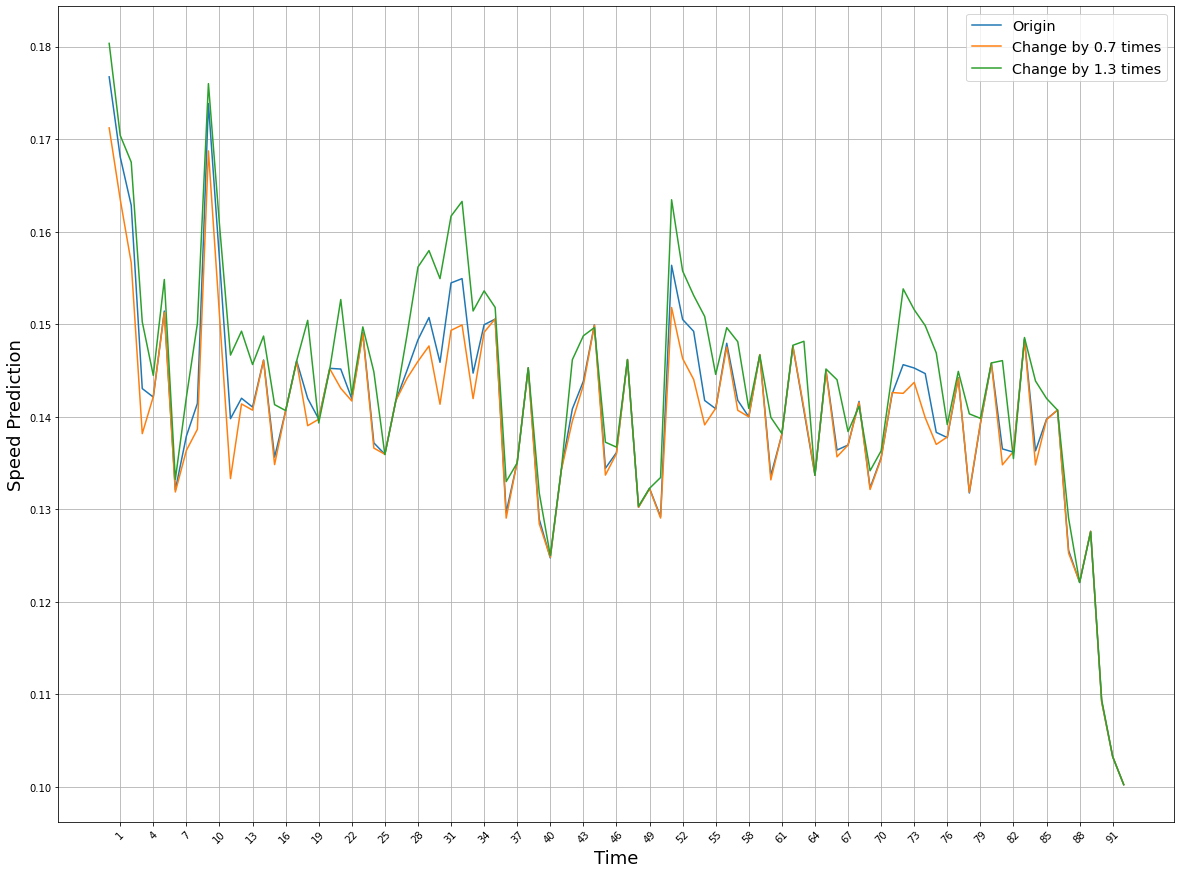

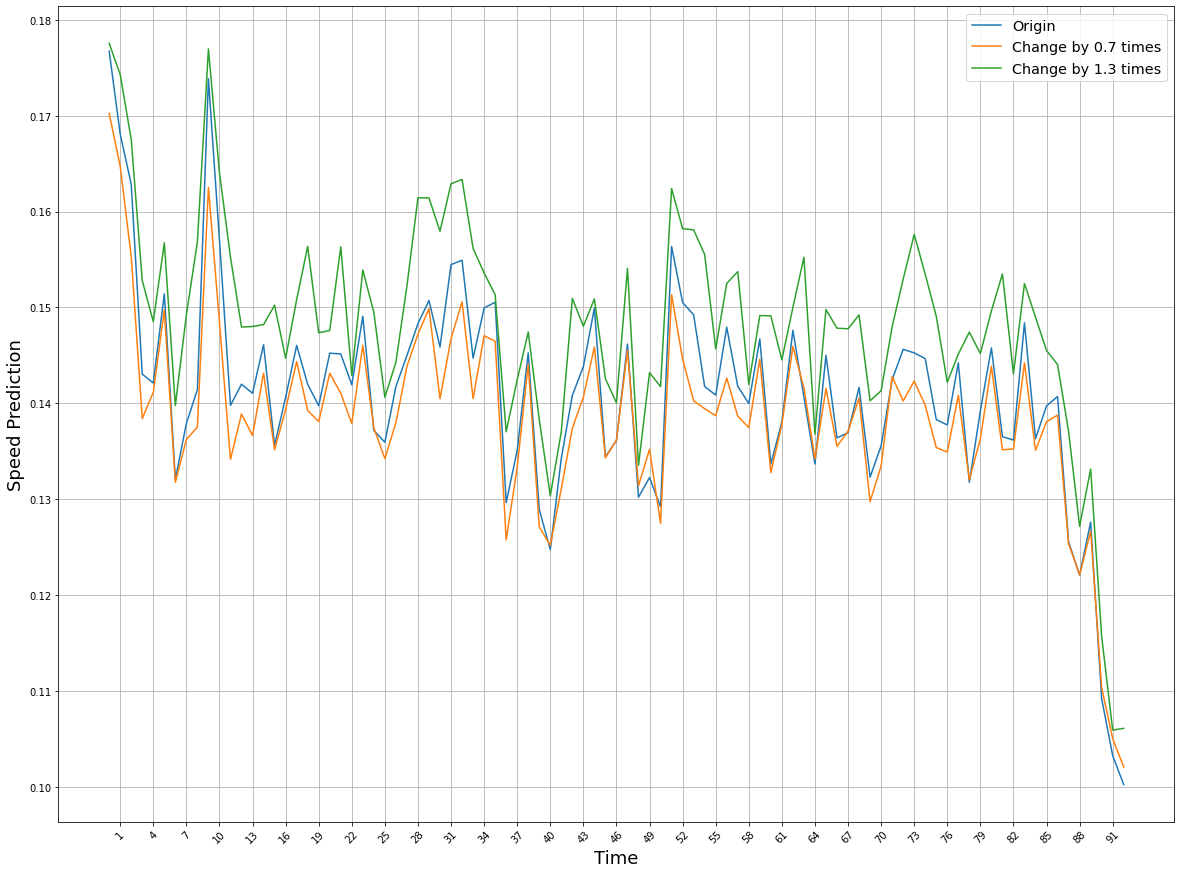

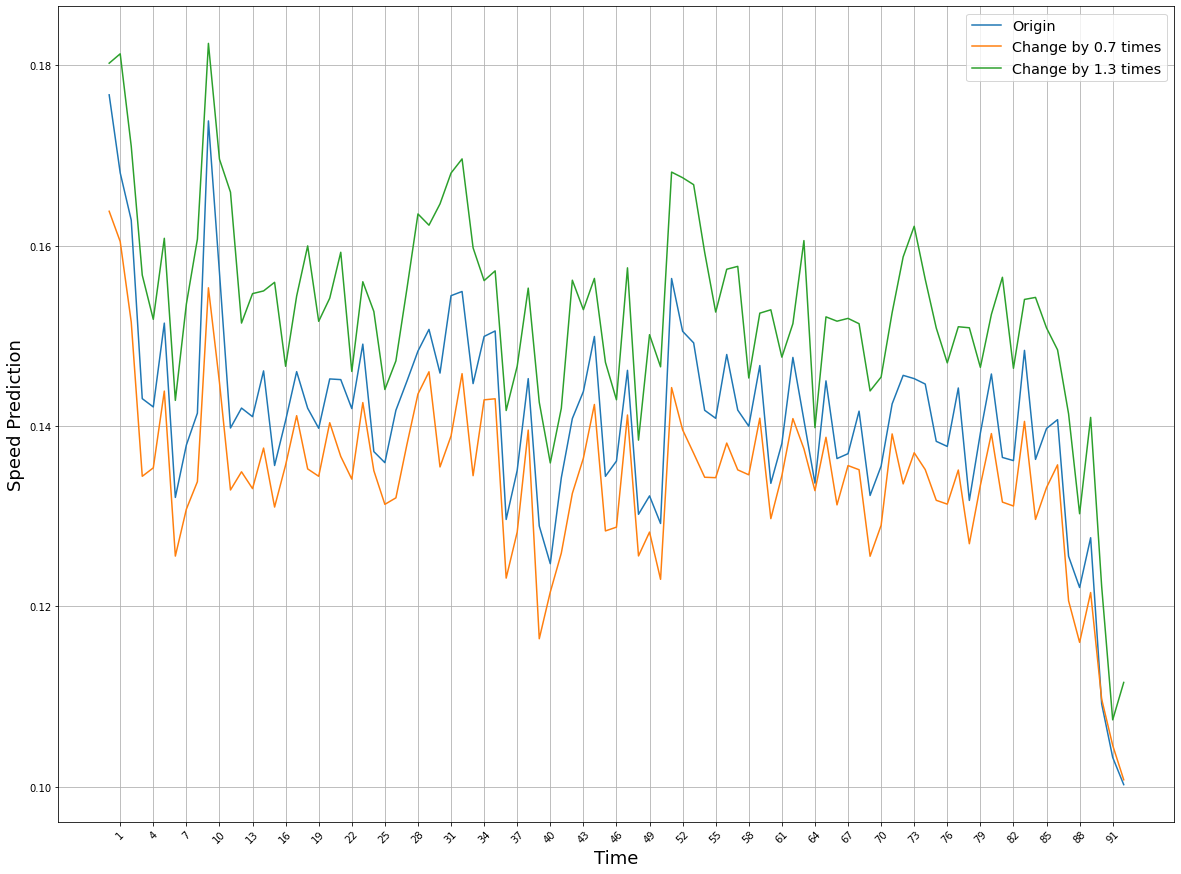

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx

  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist()

  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10



In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])

  from sklearn.feature_selection import RFE
  estimator = cb.CatBoostRegressor()
  selector = RFE(estimator, n_features_to_select = 12)

  selector.fit(input_train_df, output_train_df)
  selector.transform(input_train_df)
  selector.transform(input_test_df)
  print(dict(zip(input_train_df.columns, selector.ranking_)))


Streaming output truncated to the last 5000 lines.
5:	learn: 0.0306064	total: 33ms	remaining: 5.47s
6:	learn: 0.0297085	total: 38.6ms	remaining: 5.48s
7:	learn: 0.0289210	total: 44.1ms	remaining: 5.47s
8:	learn: 0.0281251	total: 49.6ms	remaining: 5.46s
9:	learn: 0.0274003	total: 60.1ms	remaining: 5.95s
10:	learn: 0.0266635	total: 72.2ms	remaining: 6.49s
11:	learn: 0.0260277	total: 85ms	remaining: 7s
12:	learn: 0.0254219	total: 93.2ms	remaining: 7.07s
13:	learn: 0.0248478	total: 101ms	remaining: 7.11s
14:	learn: 0.0243342	total: 109ms	remaining: 7.18s
15:	learn: 0.0238767	total: 117ms	remaining: 7.21s
16:	learn: 0.0234209	total: 129ms	remaining: 7.44s
17:	learn: 0.0230103	total: 140ms	remaining: 7.64s
18:	learn: 0.0226124	total: 150ms	remaining: 7.73s
19:	learn: 0.0222487	total: 155ms	remaining: 7.6s
20:	learn: 0.0219037	total: 161ms	remaining: 7.5s
21:	learn: 0.0216285	total: 166ms	remaining: 7.4s
22:	learn: 0.0213579	total: 172ms	remaining: 7.3s
23:	learn: 0.0210980	total: 178ms	remai

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])

  from sklearn.feature_selection import RFE
  estimator = cb.CatBoostRegressor()
  selector = RFE(estimator, n_features_to_select = 20)

  selector.fit(input_train_df, output_train_df)
  selector.transform(input_train_df)
  selector.transform(input_test_df)
  print(dict(zip(input_train_df.columns, selector.ranking_)))


Streaming output truncated to the last 5000 lines.
5:	learn: 0.0306422	total: 57.3ms	remaining: 9.49s
6:	learn: 0.0297386	total: 70.8ms	remaining: 10s
7:	learn: 0.0288740	total: 79ms	remaining: 9.79s
8:	learn: 0.0281010	total: 86.6ms	remaining: 9.54s
9:	learn: 0.0273486	total: 94ms	remaining: 9.31s
10:	learn: 0.0266724	total: 102ms	remaining: 9.16s
11:	learn: 0.0260431	total: 110ms	remaining: 9.09s
12:	learn: 0.0254756	total: 118ms	remaining: 8.95s
13:	learn: 0.0248961	total: 125ms	remaining: 8.83s
14:	learn: 0.0243867	total: 133ms	remaining: 8.74s
15:	learn: 0.0239098	total: 141ms	remaining: 8.67s
16:	learn: 0.0234489	total: 148ms	remaining: 8.58s
17:	learn: 0.0230504	total: 156ms	remaining: 8.51s
18:	learn: 0.0226824	total: 164ms	remaining: 8.45s
19:	learn: 0.0223110	total: 171ms	remaining: 8.39s
20:	learn: 0.0219533	total: 183ms	remaining: 8.51s
21:	learn: 0.0215929	total: 190ms	remaining: 8.45s
22:	learn: 0.0212968	total: 197ms	remaining: 8.39s
23:	learn: 0.0210246	total: 205ms	rem

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])

  from sklearn.feature_selection import RFE
  estimator = cb.CatBoostRegressor()
  selector = RFE(estimator, n_features_to_select = 3)

  selector.fit(input_train_df, output_train_df)
  selector.transform(input_train_df)
  selector.transform(input_test_df)
  print(dict(zip(input_train_df.columns, selector.ranking_)))


Streaming output truncated to the last 5000 lines.
5:	learn: 0.0305249	total: 21.9ms	remaining: 3.63s
6:	learn: 0.0296237	total: 24.4ms	remaining: 3.46s
7:	learn: 0.0287841	total: 26.9ms	remaining: 3.34s
8:	learn: 0.0279813	total: 29.3ms	remaining: 3.23s
9:	learn: 0.0272021	total: 31.8ms	remaining: 3.15s
10:	learn: 0.0265280	total: 34.2ms	remaining: 3.08s
11:	learn: 0.0258779	total: 36.7ms	remaining: 3.02s
12:	learn: 0.0252487	total: 39.2ms	remaining: 2.98s
13:	learn: 0.0246535	total: 41.6ms	remaining: 2.93s
14:	learn: 0.0240924	total: 44.1ms	remaining: 2.89s
15:	learn: 0.0236386	total: 46.5ms	remaining: 2.86s
16:	learn: 0.0231827	total: 48.9ms	remaining: 2.83s
17:	learn: 0.0227478	total: 51.4ms	remaining: 2.8s
18:	learn: 0.0223722	total: 53.8ms	remaining: 2.78s
19:	learn: 0.0220285	total: 56.2ms	remaining: 2.75s
20:	learn: 0.0216991	total: 58.6ms	remaining: 2.73s
21:	learn: 0.0214179	total: 60.9ms	remaining: 2.71s
22:	learn: 0.0211557	total: 63.3ms	remaining: 2.69s
23:	learn: 0.020865

In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = CatBoostRegressor()
    model.load_model("model")
    topidx = [3223,2982,3191,3244,3353,2979,392,2148,2970,3351]


    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      topk = topidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='xx-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=25)
    plt.ylabel('Speed Prediction',fontsize=25)
    #plt.title('Simulate Speed Prediction with Top ',str(k))

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_cb'+str(k)+'_'+str(tg)+'.png')


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
top 10
[4640]
TOP SIMULATION 10 조절
Assume Congestion(times 0.7) Mean :   -4.136351457192566
Assume Smooth(times 1.3) Mean :   7.519231344323274


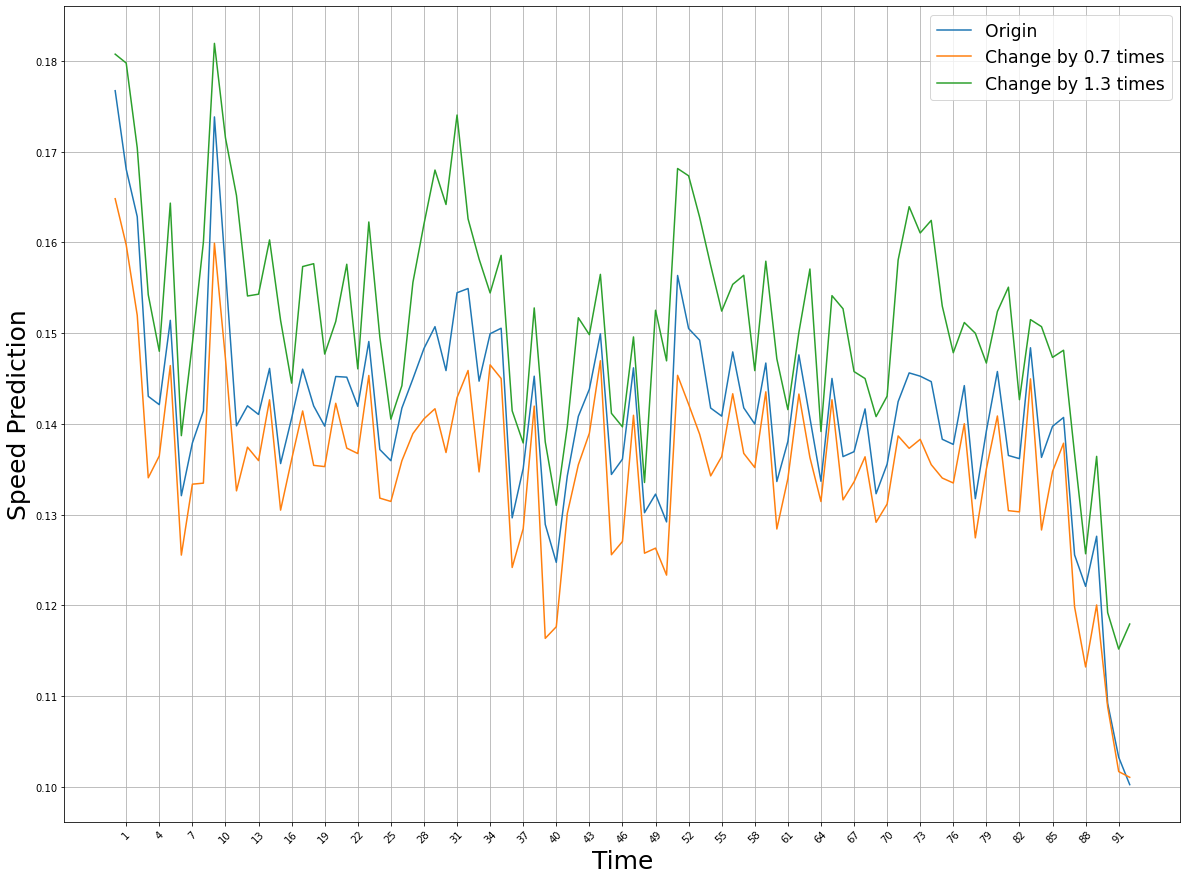

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx

  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist()


  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10



In [ ]:
!pip install shap
import shap

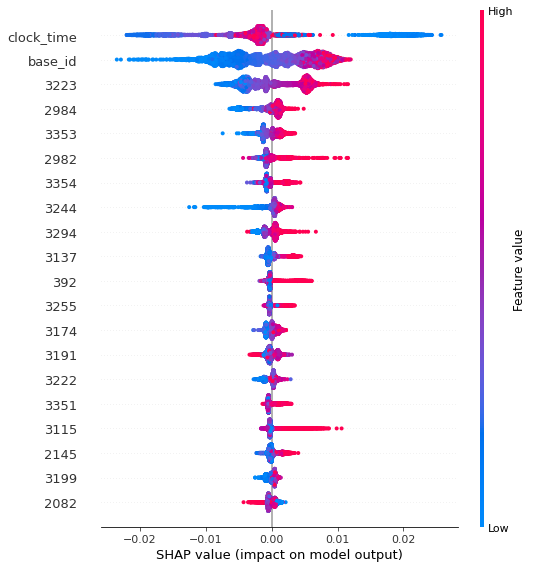

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(input_train_df)
shap.summary_plot(shap_values, input_train_df)

In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = CatBoostRegressor()
    model.load_model("model")
    topidx = [3223,2984,3353,2982,3354,3244,3294,3137,392,3255]


    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      topk = topidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      #k = bottomidx[0]

      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_shpcb'+str(k)+'_'+str(tg)+'.jpg')


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
top 10
[4640]
TOP SIMULATION 10 조절
Assume Congestion(times 0.7) Mean :   -4.893449880695715
Assume Smooth(times 1.3) Mean :   8.741635574134547


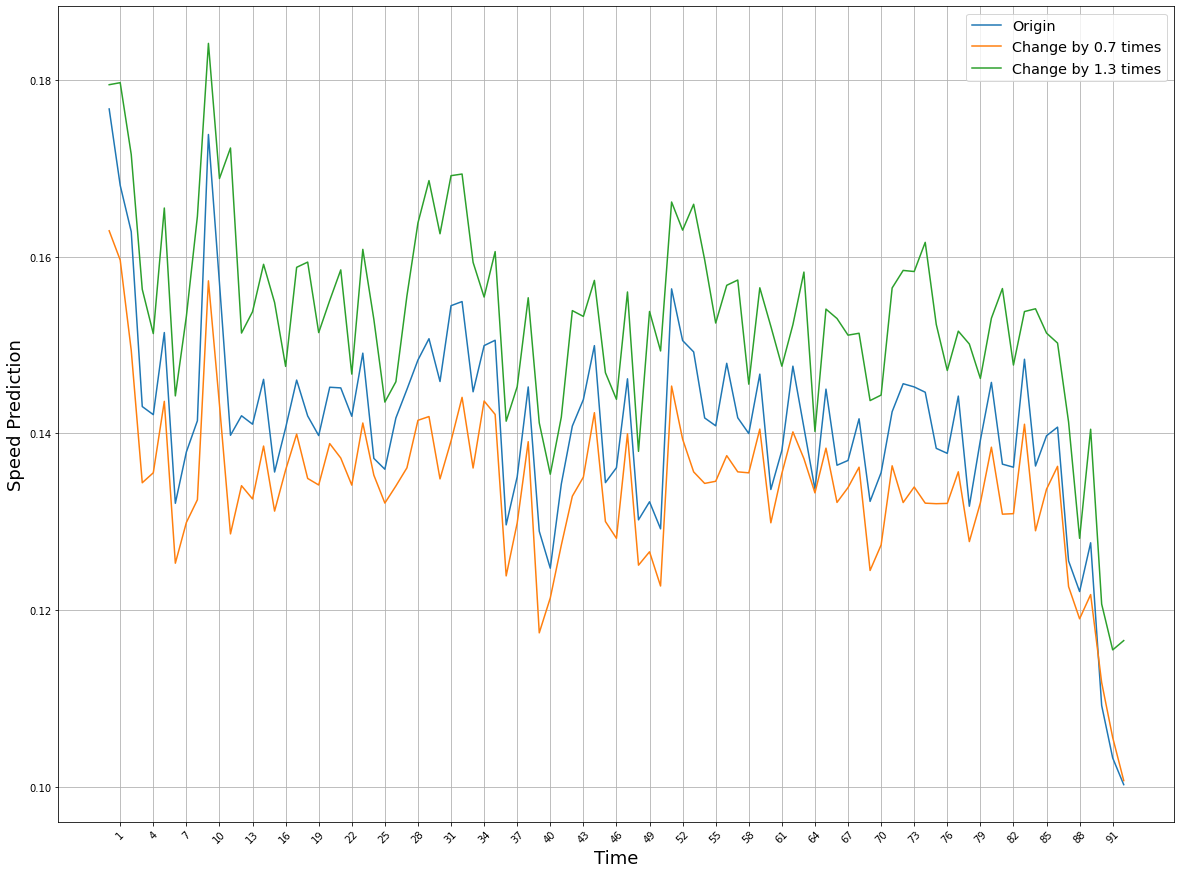

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')

  input_train_df = pd.DataFrame(input_train, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_train_df = pd.DataFrame(output_train, columns = ['(t+1)speed'])

  input_test_df = pd.DataFrame(input_test, columns = ['base_id','3190','3219','3223','3244','4629',
           '2978','2983','2984','3156','3158','3187','3191','3199','3218','3222','3245','3254','4630','4631',
           '398','2081','2083','2976','2979','2982','2985','3126','3128','3134','3136','3153','3157','3159','3167','3175','3186','3198','3230','3255','3258','4632','4641',
           '393','395','397','445','470','2082','2084','2085','2087','2145','2974','2977','3114','3115','3116','3117','3123','3127','3129','3135','3137','3152','3166','3174','3179','3231','3259','3268','3352',
           '176','389','392','394','446','455','456','469','477','2086','2088','2091','2093','2146','2147','2148','2152','2158','2164','2970','2975','3122','3178','3185','3211','3261','3269','3278','3294','3295','3344','3351','3353','3354','3355',
           'clock_time','day'])

  output_test_df = pd.DataFrame(output_test, columns = ['(t+1)speed'])

  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx

  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist()

 # print('top 1')
 # day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
 # print('top 5')
  #day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10



In [ ]:
!pip install lime
import lime

     |████████████████████████████████| 275 kB 5.0 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=ebc949f71dd141a4cde03d63dd893d40989c28b7468397c8ff0afac56493a49c
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_tabular

interpretor = lime_tabular.LimeTabularExplainer(
    training_data=np.array(input_train_df),
    feature_names= input_train_df.columns,

    mode='regression'
)

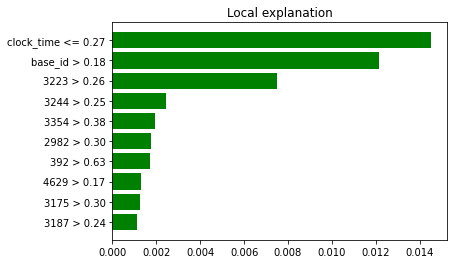

In [ ]:
exp = interpretor.explain_instance(
    data_row = input_train_df.iloc[1], ##new data
    predict_fn = model.predict)
#exp.save_to_file('lime_xgball12809.html')
fig = exp.as_pyplot_figure()

In [ ]:
def RMSE(y_test, y_predict): #판단 지표
    return np.sqrt(mean_squared_error(y_test, y_predict))
'''
def day_exp(dt,hopadj, newspeed, tg1idx, state)
input)  day = 실험해볼 시간대 ex) range(7,11) --> 고민해볼 요소!!
        hopadj
        newspeed
        tgidx = target들의 idx ex) tg1 여의나루의 경우, 6개 index
        state  = 0 : 실험용 vs state = 1: 실제용
output) tg1idx내의 각 tg 실험에 대한 결과값을 dataframe으로 저장 : 파일명 )globals()['df_' + str(tg)]
        dataframe 형식 : pd.DataFrame(columns=['BaseIdx', 'TargetIdx', 'Hop', 'Rate', 'target_src','target_dst','target_road' ])
        이때 Rate 가 실험결과 : rate = RMSE(changed, original) * 100 # 바꾸기전 예측 vs hop5 이내 노드 중 특정 targetidx를 바꾼뒤 예측 변화율
'''
def day_exp(day,hopadj, newspeed, tg1idx, state, road_name,scaled):
  if state ==0: #테스트용
    tg1idx = tg1idx[4:5]
  check = True
  print("day_exp Check : ",tg1idx)
  for tg in tg1idx:  # tg도로
    #model = keras.models.load_model("tg1_model_" + scaled+str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = CatBoostRegressor()
    model.load_model("model")
    globals()['df_'+scaled+road_name + str(tg)]  = pd.DataFrame(columns=['BaseIdx', 'TargetIdx', 'Hop','Rate07','Rate09', 'Rate11','Rate13','target_src','target_dst','target_road' ])  # 결과 값 저장 dataframe 선언

    #각각의 모든 도로가 base가 됨 : base 도로 기준 나머지 변화시켜보기
    print("==============={} Check Start=================".format(tg))
    input_d = np.asarray(make_features(hopadj, newspeed, hour_test, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기
    if check:
      check = False
      print('input_d shape : 예상(size(day),hop5이내 노드수) vs ', np.shape(input_d))
      print(input_d)
    original = model.predict(input_d)  # 바꾸기 전 값들로 예측
    real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')

    hop5idx = []
    for hopcnt in range(1, 6):
      hopidx = np.where(np.array(hopadj[tg]) == hopcnt)[0]  # base 노드와 hop cnt 인 도로들의 idx
      hop5idx.extend(hopidx)
    print('{} HOP 5 node # : {}'.format(tg, len(hop5idx)))
   ########################
   ## << 마스킹 >>
    for k in range(np.shape(input_d)[1] - 3):# 실제용, 모든 주변 노드 한개씩 바꿔보기
      #마스킹
      #input_d05 = input_d.copy()
      #input_d05[:,k+1]=input_d05[:,k+1]*0.5 #특정 노드를 0.5배 로 마스킹

      input_d07 = input_d.copy()
      input_d07[:,k+1]=input_d07[:,k+1]*0.7 #특정 노드를 0.7배로 마스킹

      input_d09 = input_d.copy()
      input_d09[:,k+1]=input_d09[:,k+1]*0.9 #특정 노드를 0.9으로 마스킹

      input_d11 = input_d.copy()
      input_d11[:,k+1]=input_d11[:,k+1]*1.1 #특정 노드를 1.1으로 마스킹

      input_d13 = input_d.copy()
      input_d13[:,k+1]=input_d13[:,k+1]*1.3 #특정 노드를 1.3으로 마스킹

      changed07 = model.predict(input_d07)  # 0.7배로 바꾼 뒤 예측
      changed09 = model.predict(input_d09)  # 0.9배로 바꾼 뒤 예측
      changed11 = model.predict(input_d11)  # 1.1배로 바꾼 뒤 예측
      changed13 = model.predict(input_d13)  # 1.3배로 바꾼 뒤 예측

      rate07 = RMSE(changed07,original) * 100 # 0.7배로 바꾼 뒤 예측
      rate09 = RMSE(changed09,original) * 100 #0.9배로 바꾼 뒤 예측
      rate11 = RMSE(changed11,original) * 100  # 1.1배로 바꾼 뒤 예측
      rate13 = RMSE(changed13,original) * 100 # 1.3배로 바꾼 뒤 예측

      # 데이터프레임 작성 위함 -> 방금 변화시킨 k번째 노드에 대한 데이터 불러오기
      targetidx = hop5idx[k]
      target_info = ginfo.iloc[targetidx][1:4]

      data = [tg, targetidx, hopadj[tg][targetidx], rate07,rate09,rate11,rate13,target_info['src'], target_info['dst'], target_info['road'] ]

      # 데이터 추가해서 원래 데이터프레임에 저장하기
      # 0배 vs original
      globals()['df_' + scaled +road_name+ str(tg)] = globals()['df_' + scaled +road_name+ str(tg)].append(pd.Series(data, index=globals()['df_' + scaled +road_name+ str(tg)].columns), ignore_index=True)

    #최종 저장
    globals()['df_' + scaled +road_name+ str(tg)].to_pickle("df_" + scaled+road_name+str(tg)+".pkl")

  for idx, tg in enumerate(tg1idx):  # tg도로
    #Rate 변화 큰 순으로 sort : dfs_
    #globals()['df_' + road_name+str(tg)] = pd.read_pickle("df_"+road_name+str(tg)+".pkl")
    #print('>> 0.5배 기준 혼잡')
    globals()['dfs07_' + scaled+road_name + str(tg)] = globals()['df_' +scaled+road_name+ str(tg)].sort_values(by=["Rate07"], ascending=[False])
    #print('>> 1.5배 기준 원활')
    globals()['dfs13_' + scaled+road_name + str(tg)] = globals()['df_' +scaled+road_name+ str(tg)].sort_values(by=["Rate13"], ascending=[False])

    df07 = globals()['dfs07_'+scaled+road_name + str(tg)].copy() #sort된 dataframe
    df13 = globals()['dfs13_'+scaled+road_name + str(tg)].copy() #sort된 dataframe

    df07 = df07.reset_index(drop=True)
    df13 = df13.reset_index(drop=True)

    print('>> 0.7 혼잡 TOP => ',df07[:20])
    print('>> 0.7 혼잡Bottom =>',df07[-20:])

    print('>> 1.3 원활 TOP => ',df13[:20])
    print('>> 1.3 원활Bottom =>',df13[-20:])




In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx


  tg1idx = tg1.index.tolist()

  if start_exp == True:


    day_exp(hour_test, hopadj, newspeed, tg1idx,state,road_name, scaled) # Experiment 1)masking method 적용 실험




hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
day_exp Check :  [4640]
===============4640 Check Start=================
input_d shape : 예상(size(day),hop5이내 노드수) vs  (2880, 109)
[[0.1917     0.2283     0.1865     ... 0.4516     0.04166667 0.5714286 ]
 [0.2155     0.2474     0.2097     ... 0.4495     0.08333334 0.5714286 ]
 [0.2359     0.2842     0.2115     ... 0.4505     0.125      0.5714286 ]
 ...
 [0.1473     0.1951     0.1746     ... 0.3422     0.9166667  0.71428573]
 [0.1473     0.1916     0.1793     ... 0.3392     0.9583333  0.71428573]
 [0.1468     0.188

In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = CatBoostRegressor()
    model.load_model("model")
    topidx = [3129,3223,446,3167,2982,3115,2158,392,2984,3136]


    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      topk = topidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      #k = bottomidx[0]

      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top_test_shap'+str(k)+'_'+str(tg)+'.jpg')


hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
top 1
[4640]
TOP SIMULATION 1 조절
Assume Congestion(times 0.7) Mean :   0.392126647551373
Assume Smooth(times 1.3) Mean :   2.766484994564391
top 5
[4640]
TOP SIMULATION 5 조절
Assume Congestion(times 0.7) Mean :   -0.7342489075091303
Assume Smooth(times 1.3) Mean :   8.038353635367976
top 10
[4640]
TOP SIMULATION 10 조절
Assume Congestion(times 0.7) Mean :   -1.6439209918185254
Assume Smooth(times 1.3) Mean :   7.8886182884751275


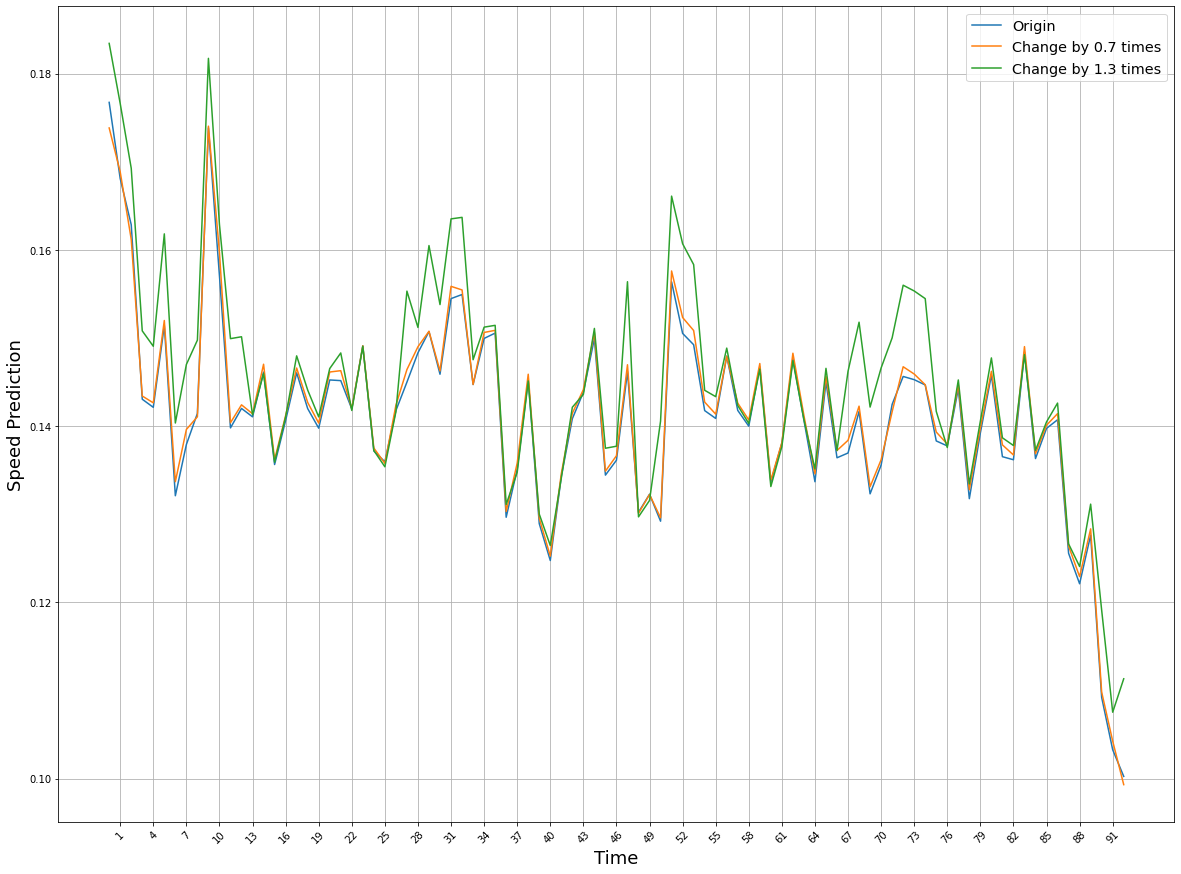

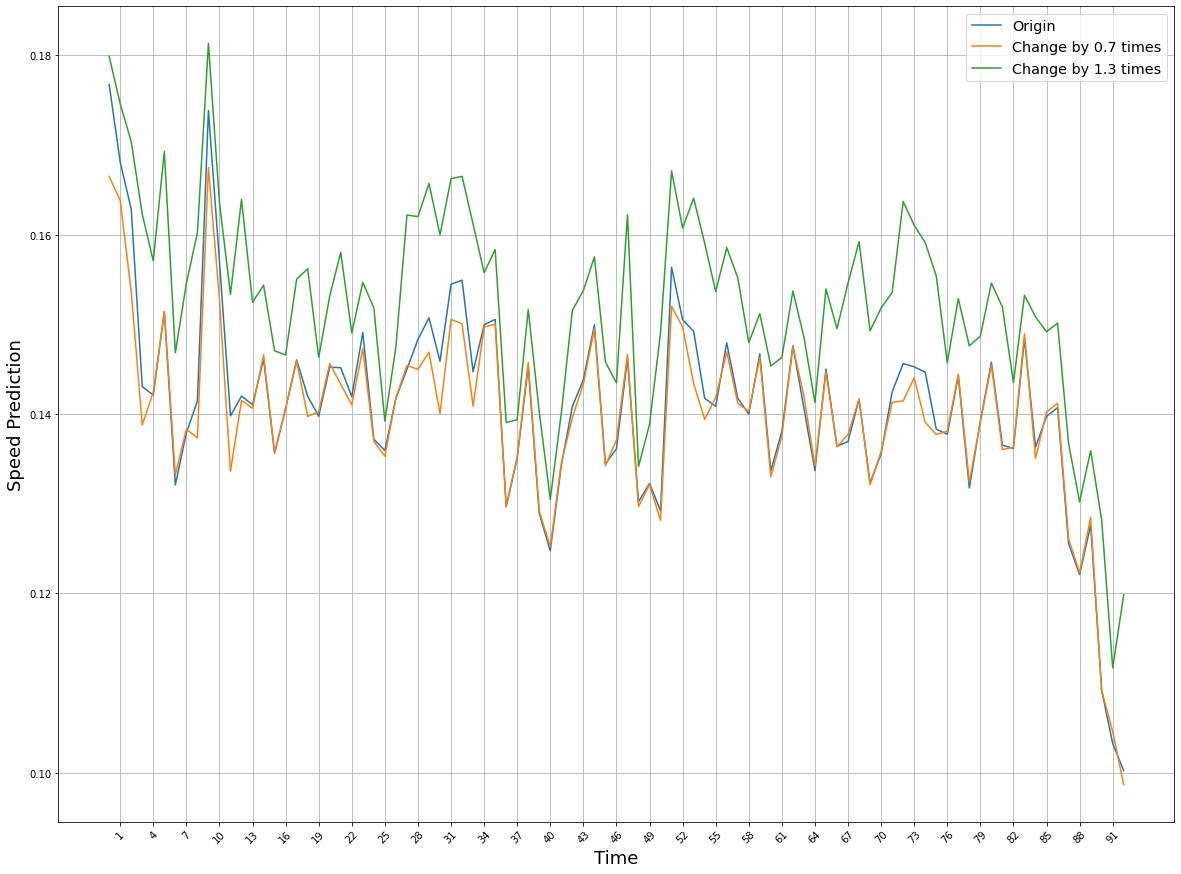

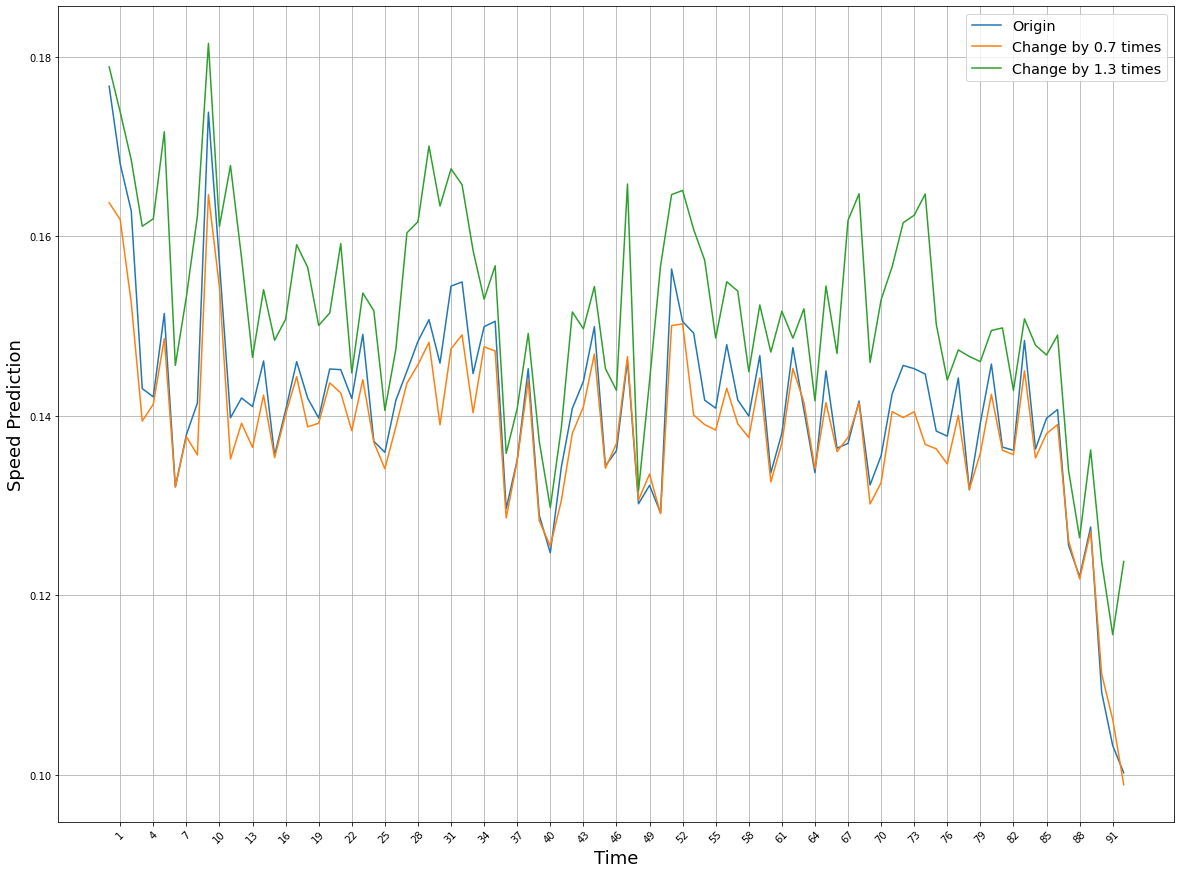

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')


  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx

  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist()

  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10



In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = CatBoostRegressor()
    model.load_model("model")
    topidx = [3129,3223,446,3167,2982,3115,2158,392,2984,3136]


    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      topk = topidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      #k = bottomidx[0]

      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Top ',str(k))

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_masking_topcb'+str(k)+'_'+str(tg)+'.jpg')

def day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]

  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    model = CatBoostRegressor()
    model.load_model("model")
    bottomidx = [2084,455,2088,3128,3134,3258,3355,2085,4632,3186]

    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      bottomk = bottomidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][bottomk] = changespeed05[t][bottomk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      changespeed15 = newspeed.copy()
      changespeed15[t][bottomk] = changespeed15[t][bottomk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Bottom 10')

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('BOTTOM SIMULATION')
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("change07 Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("change13 Mean :  ",np.mean(np.divide(d2,origin) *100))

    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('simulate_masking_bottomcb'+str(tg)+'.jpg')



hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
top 1
[4640]
TOP SIMULATION 1 조절
Assume Congestion(times 0.7) Mean :   0.392126647551373
Assume Smooth(times 1.3) Mean :   2.766484994564391
top 5
[4640]
TOP SIMULATION 5 조절
Assume Congestion(times 0.7) Mean :   -0.7342489075091303
Assume Smooth(times 1.3) Mean :   8.038353635367976
top 10
[4640]
TOP SIMULATION 10 조절
Assume Congestion(times 0.7) Mean :   -1.6439209918185254
Assume Smooth(times 1.3) Mean :   7.8886182884751275
bottom 10
BOTTOM SIMULATION
change07 Mean :   0.46012323

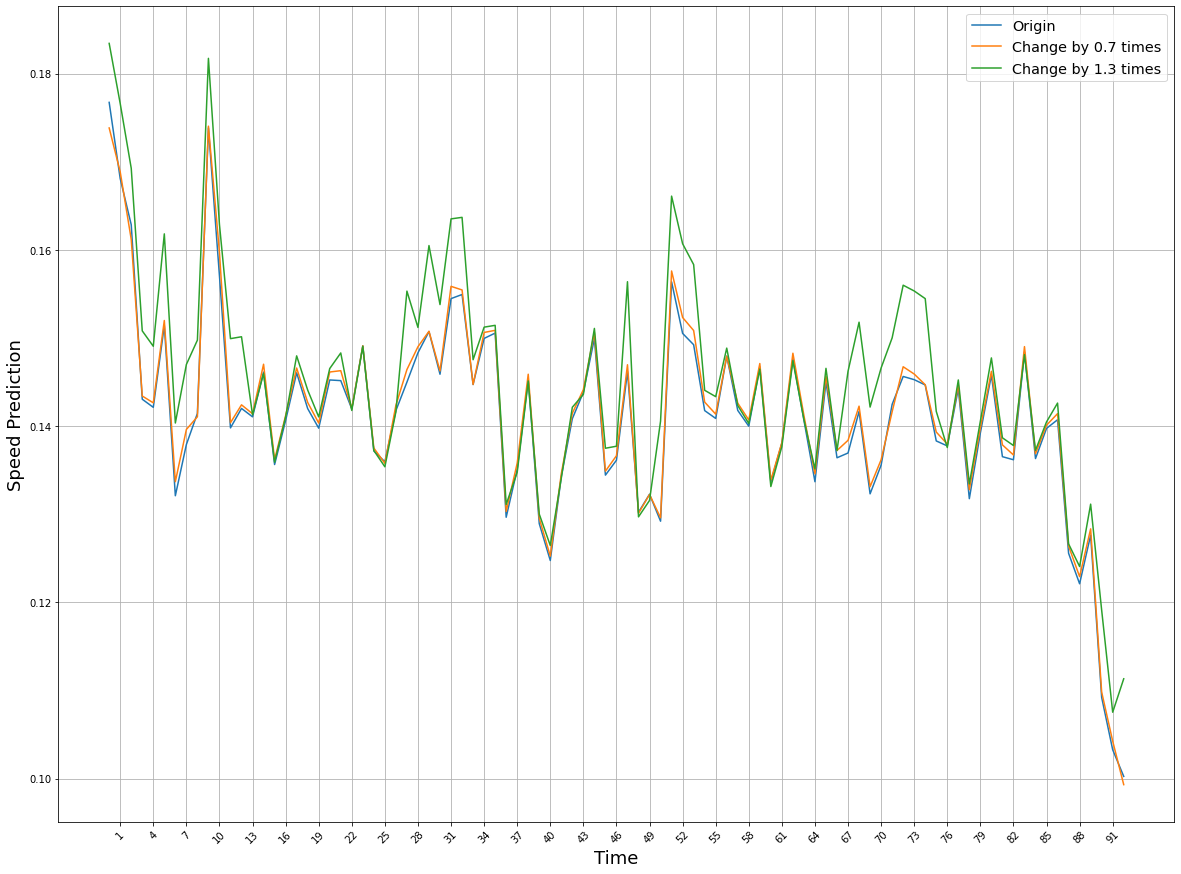

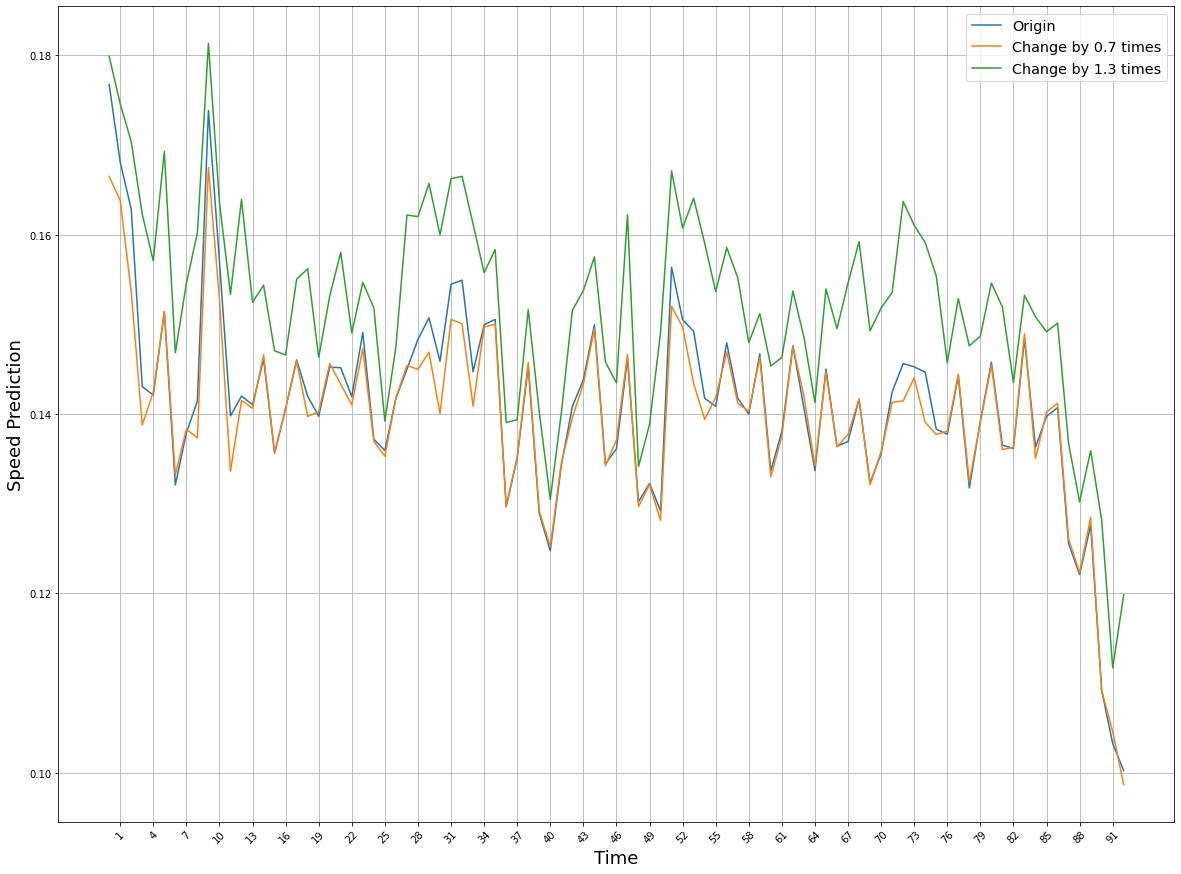

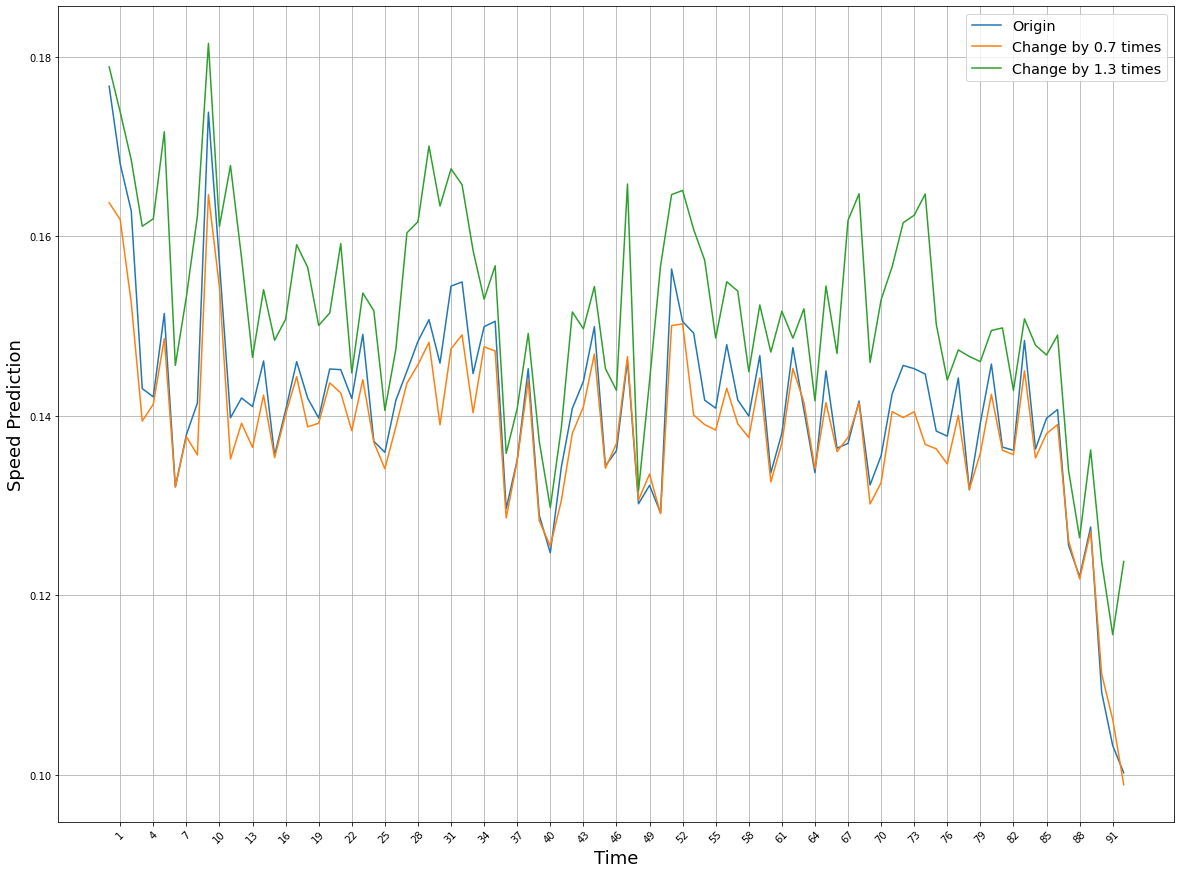

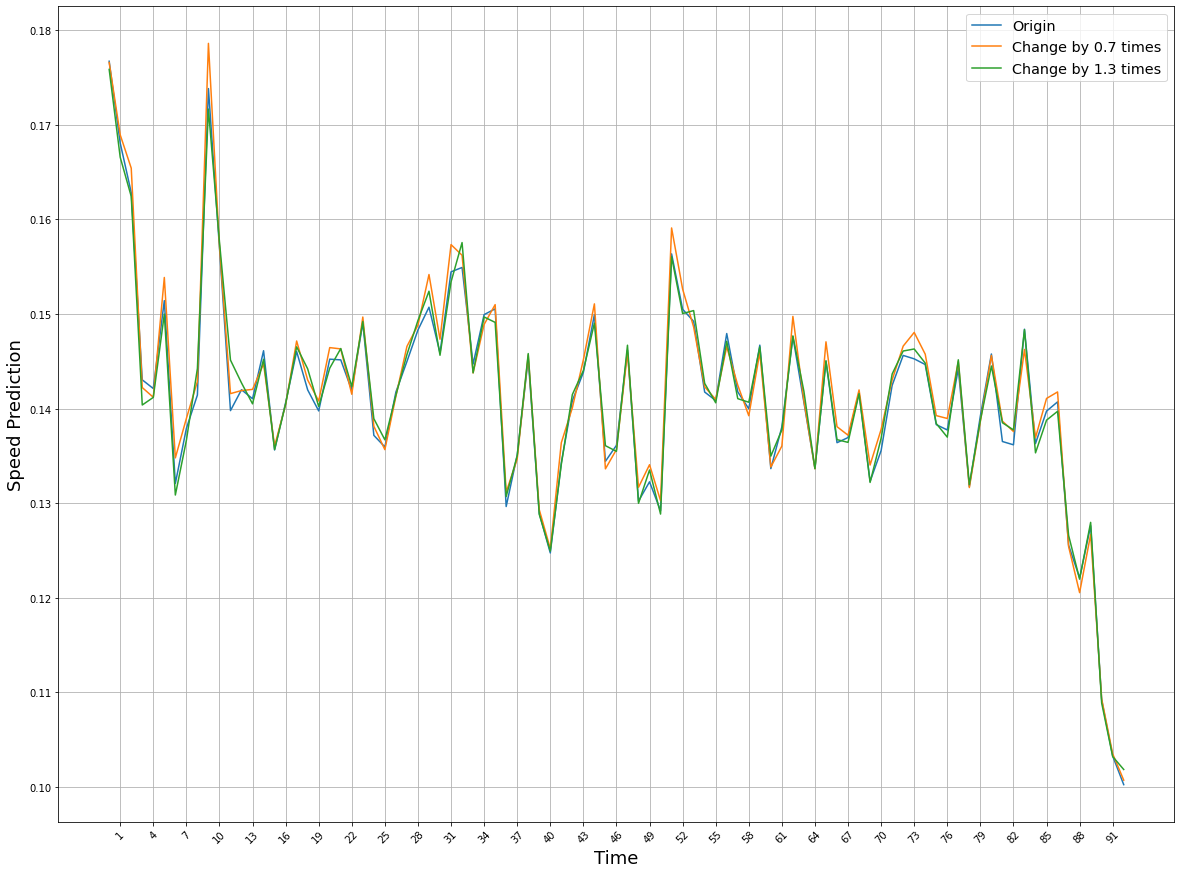

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')


  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx

  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist()

  print('top 1')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5
  print('top 10')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10

  print('bottom 10')
  day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10



In [ ]:

pd.set_option('display.max_columns', 100)


def day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]

  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    model = CatBoostRegressor()
    model.load_model("model")
    bottomidx = [3355,2974,2088,2084,3258,3219,398,455,3218,3158]

    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      bottomk = bottomidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][bottomk] = changespeed05[t][bottomk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      changespeed15 = newspeed.copy()
      changespeed15[t][bottomk] = changespeed15[t][bottomk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='x-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=18)
    plt.ylabel('Speed Prediction',fontsize=18)
    #plt.title('Simulate Speed Prediction with Bottom 10')

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('BOTTOM SIMULATION')
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("change07 Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("change13 Mean :  ",np.mean(np.divide(d2,origin) *100))

    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('simulate_fi_bottomcb'+str(tg)+'.jpg')



hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
bottom 10
BOTTOM SIMULATION
change07 Mean :   0.5262083251480878
change13 Mean :   0.5597579345629292


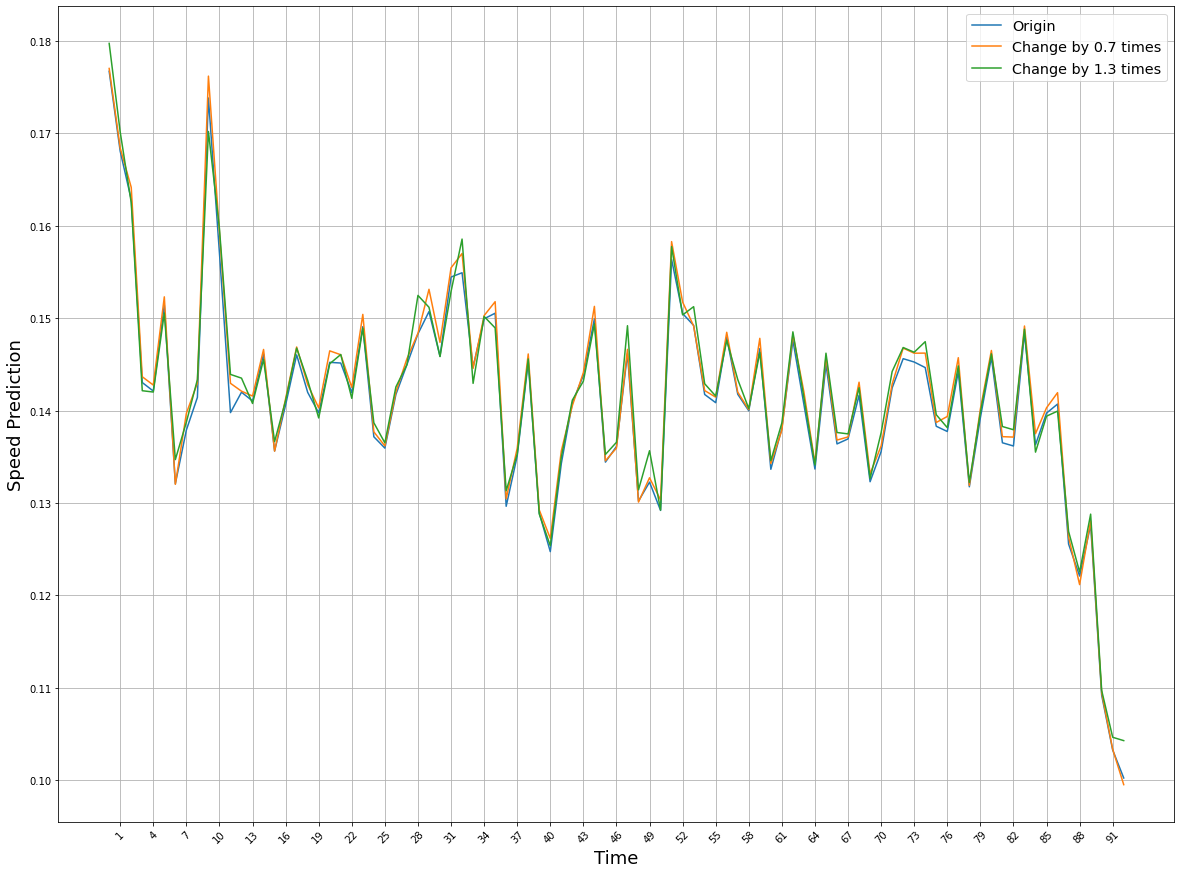

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')


  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx

  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist()


  print('bottom 10')
  day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10



In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = CatBoostRegressor()
    model.load_model("model")
    topidx = [3223,2148,3244,2982,392,2984,469,2970,2093,3294]


    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      topk = topidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      #k = bottomidx[0]

      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='xx-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=25)
    plt.ylabel('Speed Prediction',fontsize=25)
    #plt.title('Simulate Speed Prediction with Top ',str(k))

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_rfe_topcb'+str(k)+'_'+str(tg)+'.jpg')

def day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name,scaled,k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]

  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    model = CatBoostRegressor()
    model.load_model("model")
    bottomidx = [3355,398,3174,3218,393,2974,2088,3126,3344,2985]

    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      bottomk = bottomidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][bottomk] = changespeed05[t][bottomk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      changespeed15 = newspeed.copy()
      changespeed15[t][bottomk] = changespeed15[t][bottomk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='xx-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=25)
    plt.ylabel('Speed Prediction',fontsize=25)
    #plt.title('Simulate Speed Prediction with Bottom 10')

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('BOTTOM SIMULATION')
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("change07 Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("change13 Mean :  ",np.mean(np.divide(d2,origin) *100))

    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('simulate_rfe_bottomcb'+str(tg)+'.png')



hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
top 1
top 5
top 10
bottom 10
BOTTOM SIMULATION
change07 Mean :   0.27337447180575963
change13 Mean :   -0.3125967290981196


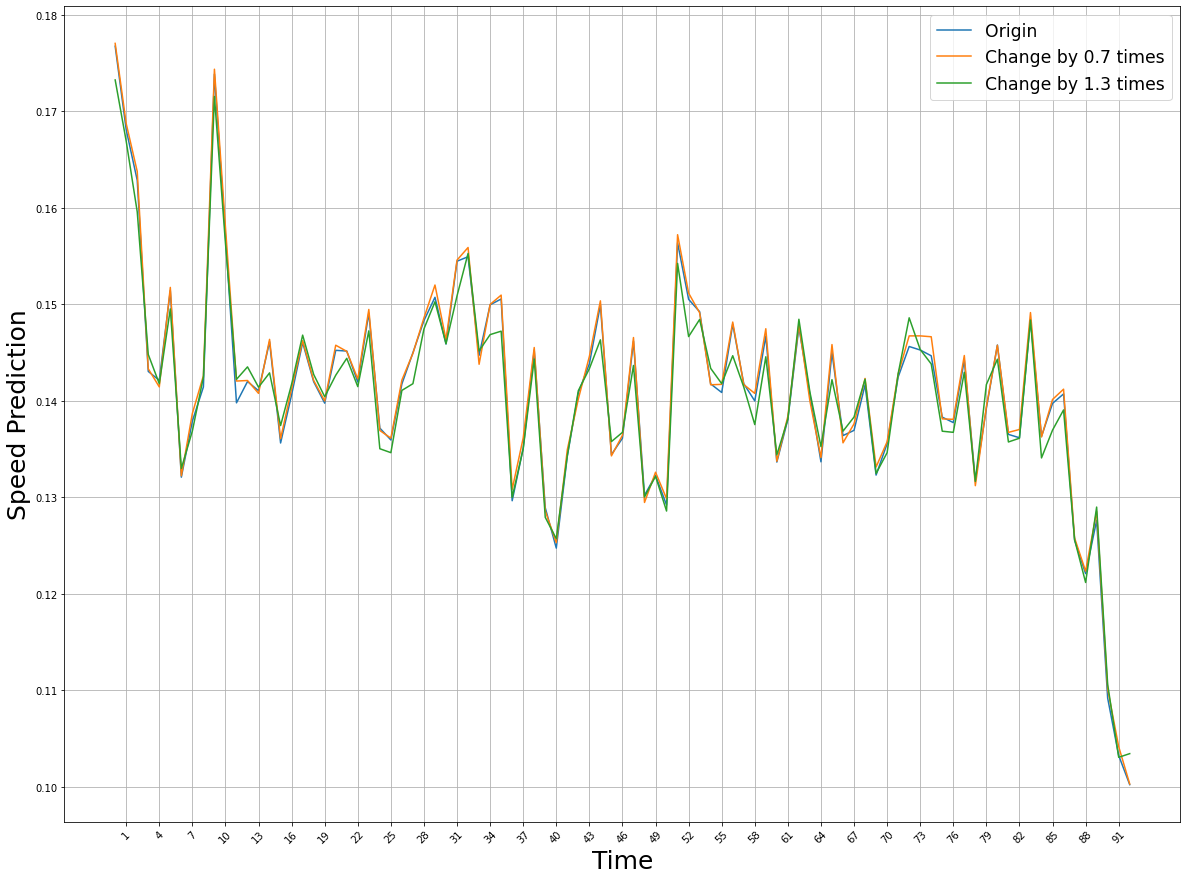

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')


  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx

  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist()

  print('top 1')
  #day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,1) # Experiment 2) Control only top1
  print('top 5')
 # day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5
  print('top 10')
 # day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10

  print('bottom 10')
  day_simulation_bottomk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,10)# Exp 2) Control top10



In [ ]:

pd.set_option('display.max_columns', 100)

def day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled, k):
  if state ==0 :
    tg1idx =  tg1idx[4:5]
  print(tg1idx)
  for tg in tg1idx:
    origin = []
    change05 = []
    change15 = []
    #model = keras.models.load_model("tg1_model_"+scaled + str(tg))  # tg별 학습 시켜둔 예측 모델 불러오기
    model = CatBoostRegressor()
    model.load_model("model")
    topidx = [3223,2982,2984,392,3244]


    for t in day:
      #real_output = np.asarray(make_output(newspeed, day, tg)).astype('float32')
      input_d = np.asarray(make_features_simulation(hopadj, newspeed, t, tg)).astype('float32')  # features 2차원 (size(day),hop5이내 노드수) --> 바꾸기 전 원래 속도로 features 만들기

      original_pred = model.predict(np.reshape(input_d,(1,-1)))  # 바꾸기 전 값들로 예측
      origin.append(original_pred.item())

      topk = topidx[0:k]

      changespeed05 = newspeed.copy()
      changespeed05[t][topk] = changespeed05[t][topk] * 0.7
      input_d05 = np.asarray(make_features_simulation(hopadj, changespeed05, t, tg)).astype('float32')
      change_pred05 = model.predict(np.reshape(input_d05,(1,-1)))  # 바꾸기 전 값들로 예측
      change05.append(change_pred05.item())

      #k = bottomidx[0]

      changespeed15 = newspeed.copy()
      changespeed15[t][topk] = changespeed15[t][topk] * 1.3
      input_d15 = np.asarray(make_features_simulation(hopadj, changespeed15, t, tg)).astype('float32')
      change_pred15 = model.predict(np.reshape(input_d15,(1,-1)))  # 바꾸기 전 값들로 예측
      change15.append(change_pred15.item())

    fig = plt.figure(figsize = (20,15))
    plt.grid(True)


    plt.rc('legend', fontsize='xx-large', loc='upper right')
    clock = np.arange(1,len(day))
    plt.xticks(ticks = clock, rotation = 45)
    plt.xlabel('Time',fontsize=25)
    plt.ylabel('Speed Prediction',fontsize=25)
    #plt.title('Simulate Speed Prediction with Top ',str(k))

    plt.plot(origin, label = "Origin")
    plt.plot(change05, label = "Change by 0.7 times")
    plt.plot(change15, label = "Change by 1.3 times")

    print('TOP SIMULATION {} 조절'.format(k))
    d1 = [a_i - b_i for a_i, b_i in zip(change05, origin)]
    print("Assume Congestion(times 0.7) Mean :  ",np.mean(np.divide(d1,origin) *100))

    d2 = [a_i - b_i for a_i, b_i in zip(change15, origin)]
    print("Assume Smooth(times 1.3) Mean :  ",np.mean(np.divide(d2,origin) *100))
    plt.locator_params(axis='x', nbins=len(clock)/3)
    plt.legend()
    fig.savefig('Simulate_top5cb'+str(k)+'_'+str(tg)+'.png')





hour_train len:  5879
hour_test len :  2880
tg1 여의나루로 idx : [4629, 4630, 4631, 4632, 4640, 4641]
          str_id     src     dst   road direction dist
4629  3201505000   문화방송앞    여의도역  여의나루로        하행  485
4630  3201505100    여의도역   문화방송앞  여의나루로        상행  485
4631  3201505200    여의도역   윤중초교앞  여의나루로        하행  398
4632  3201505300   윤중초교앞    여의도역  여의나루로        상행  398
4640  3201506200  여의중고교앞   문화방송앞  여의나루로        하행  455
4641  3201506300   문화방송앞  여의중고교앞  여의나루로        상행  455
** Current : 4640 out of [4640]
top 5
[4640]
TOP SIMULATION 5 조절
Assume Congestion(times 0.7) Mean :   -4.224093638031859
Assume Smooth(times 1.3) Mean :   6.369637075203374


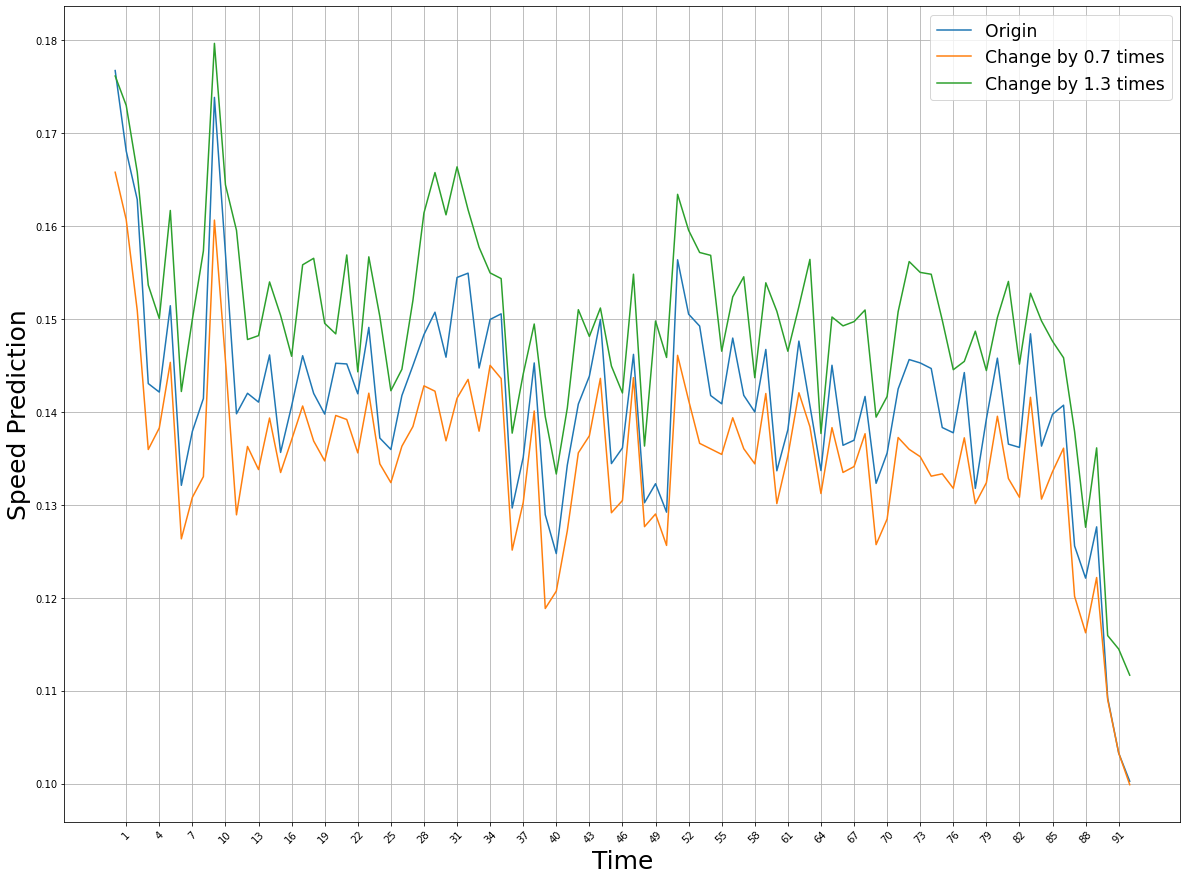

In [ ]:
if __name__=='__main__':
  #Feature scaling  (x-mean)/(std) -> newspeed.picle로 저장해둠

  #loading data
  hopadj, graphinfo, speed, lnewspeed, gnewspeed = BaseInfo()

  #np.where조건식 2개 거는 방법
  ##idx0 =  np.where( (np.array(hopadj[0]) >=1) & (np.array(hopadj[0])<=5) )[0]
  #adj 정규화  https://math.stackexchange.com/questions/3295135/how-is-the-adjacency-matrix-of-a-directed-graph-normalized

  ##########################################################################################
  #Step0) test train split
  ################################
  days = [31,28,31,30,31,30,31,31,30,31,30,31] #days of a year e.g) Jan: 31days, Feb: 28days, Mar: 31days ..
  for i in range(12):
    if i==0:
      pass
    else:
      days[i]+=days[i-1]

  month_test=[1,4,7,10]#Test: [2 Feb,5 May,8 Aug,11 Nov]
  hour_train = []
  hour_test = []

  #Split train & test data
  for i in range(12):
    if i == 0:
      tmp = range(0, days[i]*24)
    else:
      tmp = range(days[i-1] * 24, days[i]*24)
    if i in month_test:
      hour_test.extend(tmp)
    else:
      hour_train.extend(tmp)
  hour_train.pop() #NO next(t+1) data for a last day, so pop()
  print('hour_train len: ',len(hour_train))
  print('hour_test len : ', len(hour_test))

  ##########################################################################################
  #Step1) Set Base road        # e.g)'여의나루로','역삼로','방배로' road_name
  ####################################################################
  road_name = '여의나루로' # ****Set road namae****

  ginfo = pd.DataFrame(graphinfo)
  tg1 = ginfo[ginfo['road'].str.contains(road_name)]
  tg1idx = tg1.index.tolist()
  print('tg1 {} idx : {}'.format(road_name, tg1idx)) #여의나루로 tg1idx: [4629, 4630, 4631, 4632, 4640, 4641]
  print(tg1) #확인용                                  # --> 6 base roads in 'Yeoyinaru-Ro' -> each road is called 'tg' in code

  #globally하게 scaled된 speed data 사용!
  newspeed = gnewspeed
  scaled = 'G'
  ####################################
  tg1idx = tg1idx[4:5]

  for tg in tg1idx:

     #generate model for each base node
    print('** Current : {} out of {}'.format(tg,tg1idx))
    input_train = np.asarray(make_features(hopadj,newspeed, hour_train,tg)).astype('float32')
    output_train = np.asarray(make_output(newspeed, hour_train, tg)).astype('float32')

    input_test = np.asarray(make_features(hopadj, newspeed, hour_test,tg)).astype('float32')
    output_test = np.asarray(make_output(newspeed, hour_test, tg)).astype('float32')


  #########################################################
  start_exp = True # ****조절(True vs False)**** #실험 실행 여부에 따라 조절
  state = 0 # ****조절(0 vs 1)**** 0 : Simulate only one road in tg1idx vs 1 : All roads in tg1idx

  days  = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
  day = []
  for i in range(31):# Simulation Time : March(31days) 5~8pm
    day.extend(range( (days[1]+i)*24+17 , (days[1]+i)*24+20 ))
  tg1idx = tg1.index.tolist()


  print('top 5')
  day_simulation_topk(day, hopadj, newspeed, tg1idx, state, road_name, scaled,5)# Exp 2) Control top5


